<a href="https://colab.research.google.com/github/jeroee/50.038_CDS_Recycl-EZ/blob/main/Pretrained_Model_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import pickle
from natsort import natsorted
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import PIL


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model,load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers, losses,layers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas

In [ ]:
# double check keras and tensorflow version to see proper installation
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.4.3
2.3.0


In [ ]:
# declaring the paths
train_path = 'drive/My Drive/recyclables/train'
valid_path = 'drive/My Drive/recyclables/valid'
test_path = 'drive/My Drive/recyclables/test'

In [ ]:
# displaying the number of training,validation, testing data 
train_count=0
valid_count=0
test_count=0

categories = glob(train_path+'/*')
for i in categories:
  train_count+=(len(os.listdir(i)))
  
categories = glob(valid_path+'/*')
for i in categories:
  valid_count+=(len(os.listdir(i)))

categories = glob(test_path+'/*')
for i in categories:
  test_count+=(len(os.listdir(i)))

print(f'Number of training samples:{train_count}')
print(f'Number of validation samples:{valid_count}')
print(f'Number of test samples:{test_count}')

Number of training samples:3860
Number of validation samples:482
Number of test samples:479


## VGG16 Model

In [ ]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False  

model = Sequential()
model.add(vgg)
# model.add(GlobalMaxPooling2D())
# model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(categories), activation='softmax'))

In [ ]:
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 5125      
Total params: 40,410,949
Trainable params: 25,696,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                                   vertical_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

# number of training sets will be the total training data/batch size 
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
# number of validation sets will be the total test data/batch size
valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            class_mode=None,
                                            shuffle=False)

Found 3860 images belonging to 5 classes.
Found 482 images belonging to 5 classes.
Found 479 images belonging to 5 classes.


In [ ]:
# number of training and validation batches
print(f'batches of training data:{len(train_set)}')
print(f'batches of validation data:{len(valid_set)}')

batches of training data:121
batches of validation data:16


In [ ]:
#training model
r = model.fit_generator(
  train_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(train_set),
  validation_steps=len(valid_set)
)


Epoch 1/30
121/121 [==============================] - 70s 577ms/step - loss: 1.0812 - accuracy: 0.5837 - val_loss: 0.7127 - val_accuracy: 0.7531
Epoch 2/30
121/121 [==============================] - 69s 569ms/step - loss: 0.7694 - accuracy: 0.7065 - val_loss: 0.5779 - val_accuracy: 0.7739
Epoch 3/30
121/121 [==============================] - 69s 573ms/step - loss: 0.6961 - accuracy: 0.7223 - val_loss: 0.5431 - val_accuracy: 0.8216
Epoch 4/30
121/121 [==============================] - 70s 575ms/step - loss: 0.6442 - accuracy: 0.7477 - val_loss: 0.5596 - val_accuracy: 0.8091
Epoch 5/30
121/121 [==============================] - 70s 577ms/step - loss: 0.6287 - accuracy: 0.7565 - val_loss: 0.5466 - val_accuracy: 0.8216
Epoch 6/30
121/121 [==============================] - 70s 581ms/step - loss: 0.5917 - accuracy: 0.7697 - val_loss: 0.5030 - val_accuracy: 0.8382
Epoch 7/30
121/121 [==============================] - 69s 572ms/step - loss: 0.5771 - accuracy: 0.7751 - val_loss: 0.4863 - val_ac

In [ ]:
name = 'VGG16_6'
model.save(f'drive/My Drive/recyclables/VGG16_model/{name}')

INFO:tensorflow:Assets written to: drive/My Drive/recyclables/VGG16_model/VGG16_6/assets


In [ ]:
%matplotlib inline

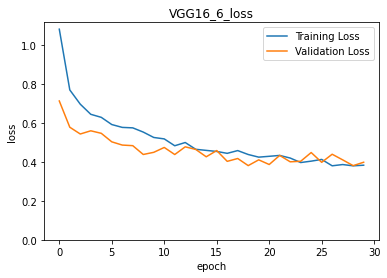

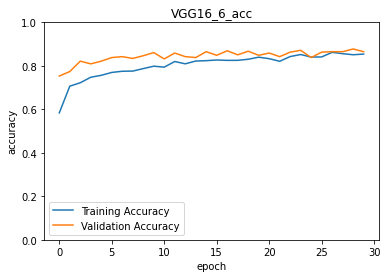

In [ ]:
loss = name+'_loss'
acc = name+'_acc'
# loss
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(loss,color='black')
plt.xlabel('epoch',color='black')
plt.ylim(ymin=0)
plt.ylabel('loss',color='black')
plt.tick_params(colors='black')
plt.savefig(f'drive/My Drive/recyclables/VGG16_model/graphs/{loss}',dpi=100,bbox_inches = 'tight')
plt.show()
# accuracy

plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title(acc,color='black')
plt.xlabel('epoch',color='black')
plt.ylim(ymin=0,ymax=1)
plt.ylabel('accuracy',color='black')
plt.tick_params(colors='black')

plt.savefig(f'drive/My Drive/recyclables/VGG16_model/graphs/{acc}',dpi=100,bbox_inches = 'tight')
plt.show()

In [ ]:
#testing model on data
print(name)
vgg16_model = f'drive/My Drive/recyclables/VGG16_model/{name}'
trained_model = load_model(vgg16_model)
y_pred = trained_model.predict(test_set)

VGG16_6


In [ ]:
predicted_labels = np.argmax(y_pred,axis=1)    #predicted labels in one hot
true_labels = test_set.labels                  #true lables in one hot
label_names = [i for i in train_set.class_indices.keys()]  #label names

In [ ]:
acc = np.count_nonzero(np.equal(predicted_labels,true_labels))/len(true_labels)
print(f'Accuracy of model on test data is {round(acc*100,2)}%\n')
report = classification_report(true_labels,predicted_labels,target_names=label_names)
print(report)

Accuracy of model on test data is 84.34%

              precision    recall  f1-score   support

   cardboard       0.98      0.91      0.94        98
       glass       0.79      0.74      0.76        95
       metal       0.87      0.80      0.84        95
       paper       0.82      0.98      0.89        98
     plastic       0.77      0.78      0.78        93

    accuracy                           0.84       479
   macro avg       0.85      0.84      0.84       479
weighted avg       0.85      0.84      0.84       479



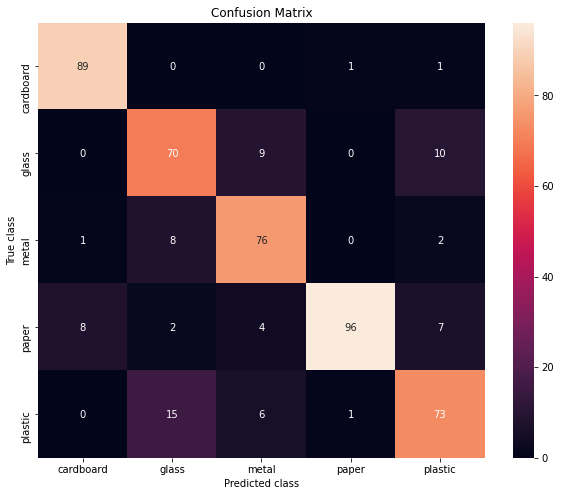

In [ ]:
cf = name+'_cf_matrix'
cf_matrix = confusion_matrix(predicted_labels,true_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#saving confusion matrix to gdrive
plt.savefig(f'drive/My Drive/recyclables/VGG16_model/graphs/{cf}')
plt.show()



---



# Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
#image size is 299x299x3
IMAGE_SIZE = [299, 299]
pre_trained_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [ ]:
#choice to retrain certain layers
for layer in pre_trained_model.layers[:-3]:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(pre_trained_model)
# model.add(Flatten())
#model.add(GlobalMaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 5125      
Total params: 23,906,085
Trainable params: 2,103,301
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation only for training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                                   vertical_flip = True)

# validation data should not be augmented
valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

# number of training sets will be the total training data/batch size 
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
# number of validation sets will be the total test data/batch size
valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(299,299),
                                            class_mode=None,
                                            shuffle=False)


# test_set2 = test_datagen.flow_from_directory('drive/My Drive/recyclables/test_2',
#                                              target_size=(299,299),
#                                               class_mode=None,
#                                               shuffle=False)

Found 3860 images belonging to 5 classes.
Found 482 images belonging to 5 classes.
Found 479 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
# checking number of batches to train
print(len(train_set))
print(len(valid_set))

121
16


In [ ]:
#training model
r = model.fit_generator(
  train_set,
  validation_data=valid_set,
  epochs=30,
  steps_per_epoch=len(train_set),
  validation_steps=len(valid_set)
)

Epoch 1/30
121/121 [==============================] - 106s 873ms/step - loss: 0.6892 - accuracy: 0.7531 - val_loss: 0.3933 - val_accuracy: 0.8548
Epoch 2/30
121/121 [==============================] - 104s 863ms/step - loss: 0.4178 - accuracy: 0.8484 - val_loss: 0.3513 - val_accuracy: 0.8610
Epoch 3/30
121/121 [==============================] - 105s 869ms/step - loss: 0.3646 - accuracy: 0.8627 - val_loss: 0.3325 - val_accuracy: 0.8817
Epoch 4/30
121/121 [==============================] - 105s 867ms/step - loss: 0.3379 - accuracy: 0.8749 - val_loss: 0.3044 - val_accuracy: 0.8921
Epoch 5/30
121/121 [==============================] - 104s 858ms/step - loss: 0.3222 - accuracy: 0.8816 - val_loss: 0.3271 - val_accuracy: 0.8859
Epoch 6/30
121/121 [==============================] - 104s 861ms/step - loss: 0.3059 - accuracy: 0.8855 - val_loss: 0.2928 - val_accuracy: 0.8963
Epoch 7/30
121/121 [==============================] - 104s 857ms/step - loss: 0.2934 - accuracy: 0.8927 - val_loss: 0.2708 -

In [ ]:
name='InceptionV3_6'
# save model to gdrive
model.save(f'drive/My Drive/recyclables/InceptionV3_model/{name}')

INFO:tensorflow:Assets written to: drive/My Drive/recyclables/InceptionV3_model/InceptionV3_6/assets


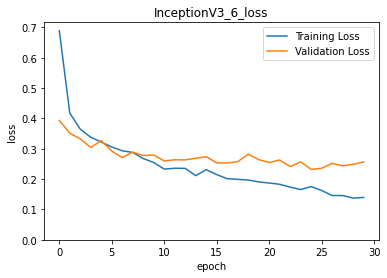

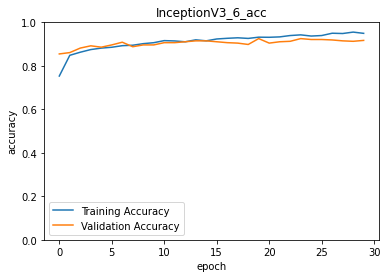

In [ ]:
loss = name+'_loss'
acc = name+'_acc'
# loss
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.ylim(ymin=0)
plt.title(loss,color='black')
plt.xlabel('epoch',color='black')
plt.ylabel('loss',color='black')
plt.tick_params(colors='black')
#save loss graph to gdrive
plt.savefig(f'drive/My Drive/recyclables/InceptionV3_model/graphs/{loss}',dpi=100,bbox_inches = 'tight')
plt.show()
# accuracy

plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.ylim(ymin=0,ymax=1)
plt.title(acc,color='black')
plt.xlabel('epoch',color='black')
plt.ylabel('accuracy',color='black')
plt.tick_params(colors='black')
#save acc graph to gdrive
plt.savefig(f'drive/My Drive/recyclables/InceptionV3_model/graphs/{acc}',dpi=100,bbox_inches = 'tight')
plt.show()

In [ ]:
#testing model on data
print(name)
inception_model = f'drive/My Drive/recyclables/InceptionV3_model/{name}'
trained_model = load_model(inception_model)
y_pred = trained_model.predict(test_set)


InceptionV3_6


In [ ]:
predicted_labels = np.argmax(y_pred,axis=1)    #predicted labels in one hot
true_labels = test_set.labels                  #true lables in one hot
label_names = [i for i in train_set.class_indices.keys()]  #label names

acc = np.count_nonzero(np.equal(predicted_labels,true_labels))/len(true_labels)
print(f'Accuracy of model on test data is {round(acc*100,2)}%\n')
report = classification_report(true_labels,predicted_labels,target_names=label_names)
print(report)

Accuracy of model on test data is 94.36%

              precision    recall  f1-score   support

   cardboard       0.97      1.00      0.98        98
       glass       0.93      0.93      0.93        95
       metal       0.91      0.98      0.94        95
       paper       0.96      0.97      0.96        98
     plastic       0.95      0.84      0.89        93

    accuracy                           0.94       479
   macro avg       0.94      0.94      0.94       479
weighted avg       0.94      0.94      0.94       479



InceptionV3_6_cf_matrix


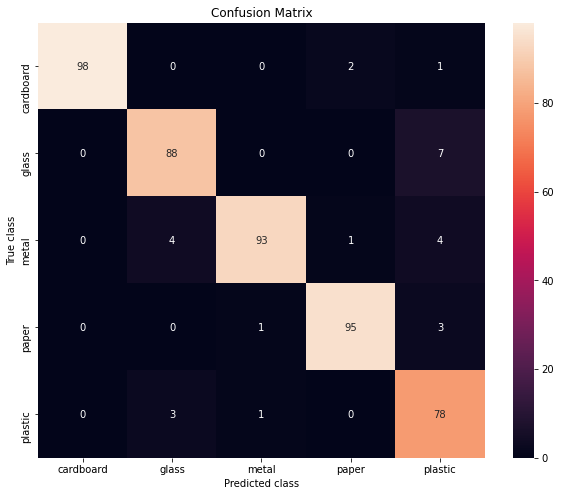

In [ ]:
cf = name+'_cf_matrix'
print(cf)
cf_matrix = confusion_matrix(predicted_labels,true_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#save confusion matrix to gdrive
plt.savefig(f'drive/My Drive/recyclables/InceptionV3_model/graphs/{cf}')
plt.show()

## Testing model on a single image to replicate steps for front end UI

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
inception = 'drive/My Drive/recyclables/InceptionV3_model/InceptionV3_8'
trained_model = load_model(inception)

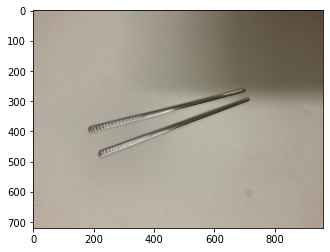

In [ ]:
# test sample image of plastic bottle taken from iphone 
image_name = 'drive/My Drive/recyclables/test_2/metal/chopstick.jpg'
img = image.load_img(image_name)
# img = image.load_img('drive/My Drive/recyclables/sample_image_2.jpg')
# img = image.load_img('drive/My Drive/recyclables/sample_image_4.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
label_names = [i for i in train_set.class_indices.keys()]  #label names
print(label_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [ ]:
#***********************************************************************
#taking in a single image
test = cv2.imread(image_name)
# test = cv2.imread('drive/My Drive/recyclables/sample_image_2.jpg')
# test = cv2.imread('drive/My Drive/recyclables/sample_image_4.jpg')
test = cv2.resize(test,(224,224))
# data preprocessing to get the input in the same shape
x = image.img_to_array(test)  # this is a Numpy array with shape (3, x, y) 
x = x * 1./255
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, x, y)

pred = trained_model.predict_classes(x)  #getting your prediction index
confidence = trained_model.predict_proba(x) #getting your prediction confidence levels
label_names = [i for i in train_set.class_indices.keys()]  #label names
print(f'Input image is predicted to be {label_names[pred[0]]} with confidence level of {round(max(confidence[0]),3)*100}%')

Input image is predicted to be metal with confidence level of 38.10000121593475%
